<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Optimization project'

In [0]:
import torch
from torch.optim import Optimizer
import math


class SUG(Optimizer):
    def __init__(self, params, l_0, d_0=0, prob=1., eps=1e-3, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if l_0 < 0.0:
            raise ValueError("Invalid Lipsitz constant of gradient: {}".format(l_0))
        if d_0 < 0.0:
            raise ValueError("Invalid disperion of gradient: {}".format(d_0))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(L=l_0, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        self.Lips = l_0
        self.prev_Lips = l_0
        self.D_0 = d_0
        self.eps = eps
        self.prob = prob
        self.start_param = params
        self.loss = torch.tensor(0.)
        self.closure = None
        super(SUG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SUG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def comp_batch_size(self):
        """Returns optimal batch size for given d_0, eps and l_0;

        """
        return math.ceil(2 * self.D_0 * self.eps / self.prev_Lips)

    def step(self, loss, closure):
        """Performs a single optimization step.

        Arguments:
            loss : current loss

            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self.start_param = []
        self.loss = loss
        self.closure = closure
        check = torch.bernoulli(torch.tensor(float(self.prob))).item()
        # self.L = min(self.L / 2, 2)
        for gr_idx, group in enumerate(self.param_groups):
            # weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                self.start_param.append({'data': p.data.clone(), 'grad': p.grad.data.clone()})
                d_p = self.start_param[-1]['grad']
                # p_ = self.start_param[-1]['data']
                # if weight_decay != 0:
                #    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
        i = 0
        difference = -1
        while difference < 0:
            if check:
                self.Lips = max(self.prev_Lips * 2 ** (i - 1), 2.)
            for j, p in enumerate(self.start_param):
                self.param_groups[0]['params'][j].data = p['data'] - 1 / (2 * self.Lips) * p['grad']
            if check:
                difference, upd_loss = self.stop_criteria()
            else:
                difference = 1
            i += 1
        self.prev_Lips = self.Lips

        return self.Lips, i

    def stop_criteria(self):
        """Checks if the Lipsitz constant of gradient is appropriate
        """
        cur_loss = self.loss.item()
        upd_loss = self.closure().item()
        #linear_part, quadratic_part = 0, 0
        delta = 0.
        for j, p in enumerate(self.start_param):
            #delta = (self.param_groups[0]['params'][j].data - p['data'])
            #linear_part += torch.sum(p['grad'] * delta)
            #quadratic_part += torch.sum(delta * delta)
            delta += torch.sum(p['grad'] * p['grad'])
        """ <g(x_k), w_k - x_k> + 2L_k / 2 ||x_k - w_k||^2 = - 1 / (2L_k)||g(x_k)||^2 + 1 / (4L_k)||g(x_k)||^2 = -1 / (4L_k)||g(x_k)||^2
        """
        major =  cur_loss - 1 / (4 * self.Lips) * delta
        #return cur_loss - upd_loss + linear_part + self.Lips * quadratic_part + self.eps / 10, upd_loss
        return major - upd_loss + self.eps / 10, upd_loss

    def get_lipsitz_const(self):
        """ Returns current Lipsitz constant of the gradient of the loss function
        """
        return self.Lips

In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import time
import pandas as pd
import numpy as np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [0]:
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## Data

In [7]:
BATCH_SIZE = 4

# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 24846339.61it/s]                            


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 459106.21it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143504.31it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6985612.58it/s]                           
8192it [00:00, 179274.44it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Labels:  tensor([8, 4, 8, 0])
Batch shape:  torch.Size([4, 1, 28, 28])


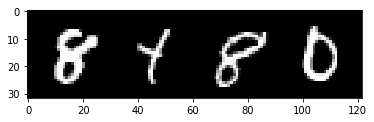

In [8]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

## Model (Fully Connected nn)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(BATCH_SIZE, -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

## Train

In [0]:
import time
import math


def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward(retain_graph=True)
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, eps=1e-5, print_every=1):
    losses = []
    start_time = time.time()
    model.to(device=device).train()
    for ep in range(n_epochs):
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            losses.append(model_step(model, optimizer, criterion, inputs, labels))

        if ep % print_every == 0:
            print("Epoch {}, loss {}, time passed {}".format(ep, sum(losses[-i:]) / i, time_since(start_time)))
        
    return losses

In [0]:
def train_lips(model, trainloader, criterion, optimizer, n_epochs=2, eps=1e-5, print_every=1):
    losses = []
    lips = []
    start_time = time.time()
    model.to(device).train()
    for ep in range(n_epochs):
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            losses.append(model_step(model, optimizer, criterion, inputs, labels))
            lips.append(optimizer.get_lipsitz_const())
        
        if ep % print_every == 0:
            print("Epoch {}, loss {}, time passed {}".format(ep, sum(losses[-i:]) / i, time_since(start_time)))
            print("Lipsitz constant {}".format(optimizer.get_lipsitz_const()))

    return losses, lips

In [0]:
print_every = 1
n_epochs = 20
losses = {}
losses['sgd'] = {}
lrs = [0.01, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [18]:
for lr in lrs:
  print("Trining for SGD lr={}, momentum=0.".format(lr))
  net = Net()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.)
  losses['sgd'][lr] = train(net, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every)

Trining for SGD lr=0.01, momentum=0.
Epoch 0, loss 0.36580407882946414, time passed 0m 34s
Epoch 1, loss 0.174382395943496, time passed 1m 8s
Epoch 2, loss 0.12343576740237806, time passed 1m 41s
Epoch 3, loss 0.09451616586498503, time passed 2m 16s
Epoch 4, loss 0.07664835908443295, time passed 2m 49s
Epoch 5, loss 0.06389725618588463, time passed 3m 25s
Epoch 6, loss 0.05443861447729201, time passed 3m 58s
Epoch 7, loss 0.04666706029713428, time passed 4m 33s
Epoch 8, loss 0.04015328068639113, time passed 5m 10s
Epoch 9, loss 0.03512205968054782, time passed 5m 44s
Epoch 10, loss 0.030742327808038306, time passed 6m 19s
Epoch 11, loss 0.02680412347145546, time passed 6m 52s
Epoch 12, loss 0.02368735154793019, time passed 7m 27s
Epoch 13, loss 0.020776861671193678, time passed 8m 0s
Epoch 14, loss 0.018082037732016047, time passed 8m 35s
Epoch 15, loss 0.016528789437097728, time passed 9m 9s
Epoch 16, loss 0.014567439802822029, time passed 9m 44s
Epoch 17, loss 0.012790149569916752, t

In [0]:
l_0 = 2

In [21]:
net = Net()
optimizer = SUG(net.parameters(), l_0=l_0, momentum=0.)
losses['sug'], lips = train_lips(net, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every)

Epoch 0, loss 0.203265562439944, time passed 1m 9s
Lipsitz constant 8.0
Epoch 1, loss 0.09067485415186037, time passed 2m 16s
Lipsitz constant 4.0
Epoch 2, loss 0.06261476206933668, time passed 3m 22s
Lipsitz constant 4.0
Epoch 3, loss 0.046829636625166184, time passed 4m 27s
Lipsitz constant 8.0
Epoch 4, loss 0.036787328918629215, time passed 5m 30s
Lipsitz constant 2.0
Epoch 5, loss 0.02969363037129467, time passed 6m 34s
Lipsitz constant 8.0
Epoch 6, loss 0.02390702867263142, time passed 7m 37s
Lipsitz constant 2.0
Epoch 7, loss 0.020005289503189475, time passed 8m 39s
Lipsitz constant 2.0
Epoch 8, loss 0.01688876032980293, time passed 9m 41s
Lipsitz constant 32.0
Epoch 9, loss 0.013924624659361954, time passed 10m 41s
Lipsitz constant 2.0
Epoch 10, loss 0.012038456888165154, time passed 11m 43s
Lipsitz constant 4.0
Epoch 11, loss 0.010798177104591092, time passed 12m 44s
Lipsitz constant 2.0
Epoch 12, loss 0.009075291618218986, time passed 13m 44s
Lipsitz constant 8.0
Epoch 13, los

In [27]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /tmp
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [0]:
batchs_per_epoch = 60000 // BATCH_SIZE

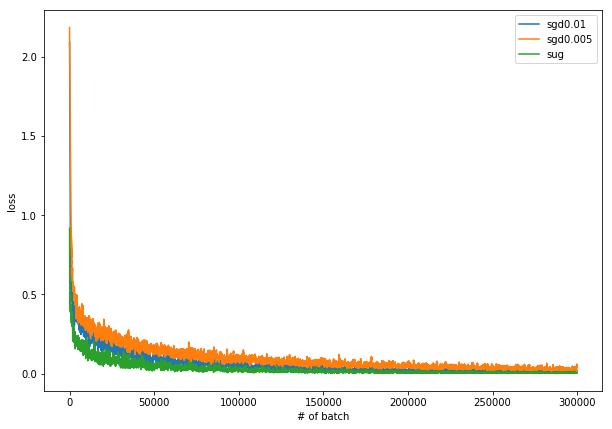

In [30]:
figure = plt.figure(figsize=(10,7))
for lr in lrs:
    plt.plot([np.mean(losses['sgd'][lr][i:i+200]) for i in range(len(losses['sgd'][lr])-200)], label='sgd'+str(lr))
plt.plot([np.mean(losses['sug'][i:i+200]) for i in range(len(losses['sug'])-200)], label="sug")
plt.xlabel("# of batch")
plt.ylabel("loss")
plt.legend()
plt.show()

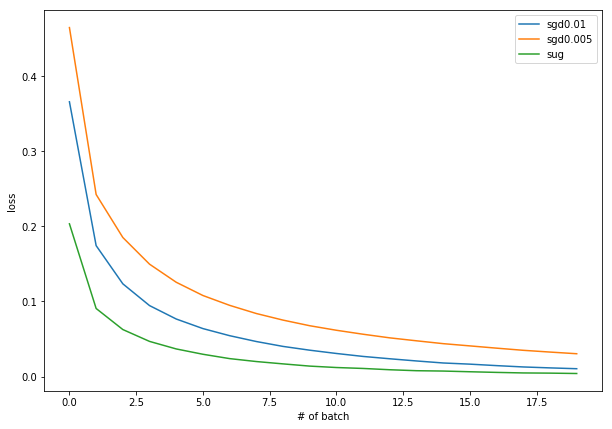

In [33]:
figure = plt.figure(figsize=(10,7))
for lr in lrs:
    plt.plot([sum(losses['sgd'][lr][i*batchs_per_epoch:(i+1)*batchs_per_epoch])/batchs_per_epoch for i in range(n_epochs)], label='sgd'+str(lr))
plt.plot([sum(losses['sug'][i*batchs_per_epoch:(i+1)*batchs_per_epoch])/batchs_per_epoch for i in range(n_epochs)], label="sug")
plt.xlabel("# of batch")
plt.ylabel("loss")
plt.legend()
plt.show()

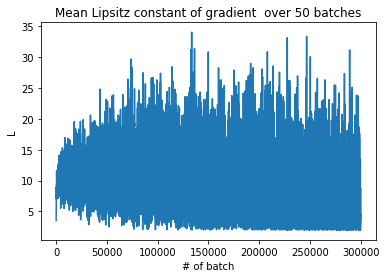

In [34]:
smooth_over = 50
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(smooth_lips)
plt.title("Mean Lipsitz constant of gradient  over {} batches".format(smooth_over))
plt.xlabel("# of batch")
plt.ylabel("L")
#plt.legend()
plt.show()

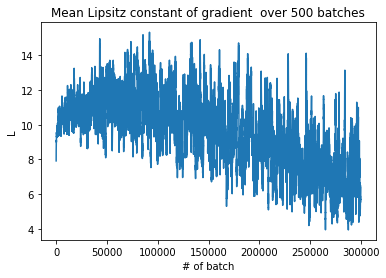

In [35]:
smooth_over = 500
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(smooth_lips)
plt.title("Mean Lipsitz constant of gradient  over {} batches".format(smooth_over))
plt.xlabel("# of batch")
plt.ylabel("L")
#plt.legend()
plt.show()

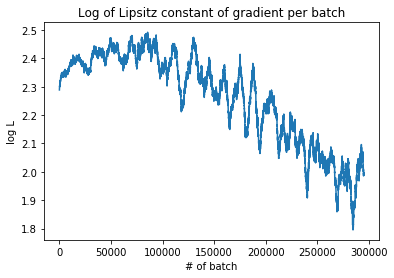

In [36]:
smooth_over = 5000
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(np.log(smooth_lips))
plt.title("Log of Lipsitz constant of gradient per batch")
plt.xlabel("# of batch")
plt.ylabel("log L")
#plt.legend()
plt.show()

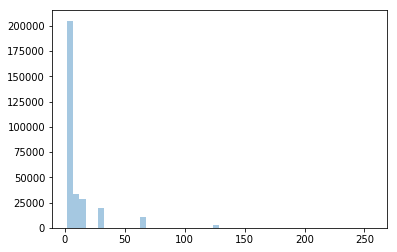

In [37]:
import seaborn as sns

sns.distplot(lips, kde=False);